## This notebook will be focused on using gradient descent to solve simple linear regression and multivariate regression problems

Note: This notebook is for educational purposes as using normal equations would be a superior approach to solving the optimization problem for the datasets that I use in this notebook.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression  # Used for validation
from sklearn import datasets
import random
import matplotlib.pyplot as plt
import pandas as pd
import latex

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import time
from sklearn.metrics import mean_squared_error

### Initially this notebook will be focused on simple linear regression

In [3]:
# Will be using the diabetes dataset with a single predictor.
diabetes = datasets.load_diabetes()
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

In [4]:
# Using sklearn's linear regression to determine the ideal output of my implementation
lr = LinearRegression()
lr.fit(X, y)
predictedVals = lr.predict(X)

print("R^2: " + str(lr.score(X, y)))
print("Coefs: " + str(lr.coef_))
print("Intercept: " + str(lr.intercept_))

R^2: 0.3439237602253803
Coefs: [949.43526038]
Intercept: 152.1334841628967


In [5]:
# Mean squared error to compare to in the future
mean_squared_error(y, predictedVals)

3890.4565854612724

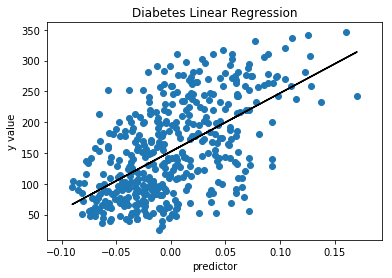

In [6]:
plt.scatter(X, y)
plt.plot(X, predictedVals, color="black")
plt.title("Diabetes Linear Regression")
plt.xlabel("predictor")
plt.ylabel("y value")
plt.show()

### In order to implement gradient descent, we must have a cost function with incorporates the weight and bias terms

I will be experimenting with a numpy based implementation and a for loop implementation and seeing if there is any significant time difference in how long it takes for the functions to run. The numpy implementation is over 10x faster.

- N: number of observations, (mx<sub>i</sub> + b) is the prediction 
$$MSE = \frac{1}{N}\sum_{i=1}^{n}(y_i - (mx_i + b))^2 $$

In [7]:
# Ensuring the shapes of the arrays are correct
# Note: if y is of the wrong shape, it messes up future equations which don't rely on for loops
y0 = y.shape[0]
x0 = X.shape[0]
y.shape = (y0,1)
X.shape = (x0,1)

In [8]:
# Cost function with numpy
def get_cost(X, y, weight, bias):
    total_error = np.average((y-(X*weight+bias))**2)
    # total_error = np.mean((y-(weight*X+bias))**2)
    return total_error

In [9]:
# Cost function with a for loop
def cost_function(X, y, weight, bias):
    total = len(X)
    total_error = 0.0
    for i in range(total):
        total_error += (y[i] - (weight*X[i] + bias))**2
    return total_error / total

In [10]:
# Testing the cost function implementation with random terms
weight = 3.1245
weight_arr = np.array([weight])
weight_arr.shape = (1,1)
bias = 0.0134
bias_arr = np.array(bias)
bias_arr.shape = (1,1)

In [11]:
start = time.clock()
parallel_cost = get_cost(X,y,weight_arr,bias_arr)
how_long = time.clock() - start
print("Took: ", how_long)
parallel_cost

Took:  0.00028799999999984394


29057.003865438077

In [12]:
start = time.clock()
normal_cost = cost_function(X,y,weight,bias)
how_long1 = time.clock() - start
print("Took: ", how_long1)
normal_cost

Took:  0.0026760000000001227


array([29057.00386544])

### Creating functions to update the weights and bias terms using gradient descent

Yet again, I will be comparing two implementations of an update_weight function, one using numpy and the other using a for loop to determine if there is a difference in performance. Within the update_weight for loop function, I will also be using the for loop implementation of mse.

$$ f(m,b) = \frac{1}{N}\sum_{i=1}^{n}(y_i-(mx_i-b))^2$$

$$ f^\prime(m,b) = \begin{split} & \frac{df}{dm} = \bigg[\frac{1}{N}\sum-2x_i(y_i-(mx_i+b))\bigg] 
\\ & \frac{df}{db} = \bigg[\frac{1}{N}\sum-2(y_i-(mx_i+b))\bigg] \end{split} $$

In [13]:
# Updating the weights, without any normalization or optimization, using numpy
def update_weights(X, y, weight, bias, lr=0.01):
    df_dm = (1/len(X)) * np.dot((-2*X).T, (y-(weight*X+bias)))
    df_db = np.average(-2*(y-(weight*X+bias)))
    weight = weight - (lr*df_dm)
    bias = bias - (lr*df_db)
    return weight,bias

In [14]:
def get_new_weights(X, y, weight, bias, learning_rate=0.01):
    weight_deriv = 0
    bias_deriv = 0
    total = len(X)
    for i in range(total):
        # -2x(y - (mx + b))
        weight_deriv += -2*X[i] * (y[i] - (weight*X[i] + bias))
        # -2(y - (mx + b))
        bias_deriv += -2*(y[i] - (weight*X[i] + bias))
        
    weight -= (weight_deriv / total) * learning_rate
    bias -= (bias_deriv / total) * learning_rate

    return weight, bias

In [15]:
# Parameters set for parameter update function testing
# The numpy implementation was around 3x faster
weight = 10.2345
bias = 6.245

In [16]:
start = time.clock()
weight1,bias1 = update_weights(X, y, weight, bias)
took = time.clock() - start
print("Using Numpy: ")
print("Weight: {}, Bias: {}".format(weight1,bias1))
print("Took: ", took)

Using Numpy: 
Weight: [[10.27699777]], Bias: 9.162769683257919
Took:  0.00043700000000024275


In [17]:
start = time.clock()
weight2,bias2 = get_new_weights(X, y, weight, bias)
took = time.clock() - start
print("Using For Loop: ")
print("Weight: {}, Bias: {}".format(weight2,bias2))
print("Took: ", took)

Using For Loop: 
Weight: [10.27699777], Bias: [9.16276968]
Took:  0.006008999999999709


### Creating a optimization loop which will update the bias and weight parameters 

I will be writing two training functions, one using the update_weight function that utilizes numpy and another that uses a simple for loop to update bias and weight terms. The numpy implementation is over 100x faster.

In [18]:
# Initializing weight and bias terms  
Weight = 0
Bias = 0

In [19]:
# Training using the numpy update_weights function
def train_numpy(X, y, weight, bias, iters, lr=0.01):
    cost = []
    for i in range(iters):
        weight, bias = update_weights(X, y, weight, bias, lr)
        a_cost = get_cost(X, y, weight, bias)
        cost.append(a_cost)

    return cost, weight, bias

In [20]:
# Training using the for loop update_weights function
def train_for(X, y, weight, bias, iters, lr=0.01):
    cost = []
    for i in range(iters):
        weight, bias = get_new_weights(X, y, weight, bias, lr)
        a_cost = cost_function(X, y, weight, bias)
        cost.append(a_cost)
        
    return cost, weight, bias

In [21]:
# Not using the forloop made optimization around 3x faster
now_time = time.clock()
numpy_cost,numpy_weight,numpy_bias = train_numpy(X, y, Weight, Bias, 7000, 0.1)
took = time.clock() - now_time
print("Took: ", took)
print("Weight: {}, Bias: {}".format(numpy_weight, numpy_bias))
print("End cost: ", numpy_cost[-1])

Took:  0.5513860000000004
Weight: [[909.48122399]], Bias: 152.1334841628966
End cost:  3894.0681805389795


In [22]:
now_time = time.clock()
for_cost,for_weight, for_bias = train_for(X, y, Weight, Bias, 7000, 0.1)
took = time.clock() - now_time
print("Took: ", took)
print("Weight: {}, Bias: {}".format(for_weight, for_bias))
print("End cost: ", for_cost[-1])

Took:  47.801306999999994
Weight: [909.48122399], Bias: [152.13348416]
End cost:  [3894.06818054]


In [23]:
# For plotting cost against time
time_seq = [i for i in range(7000)]

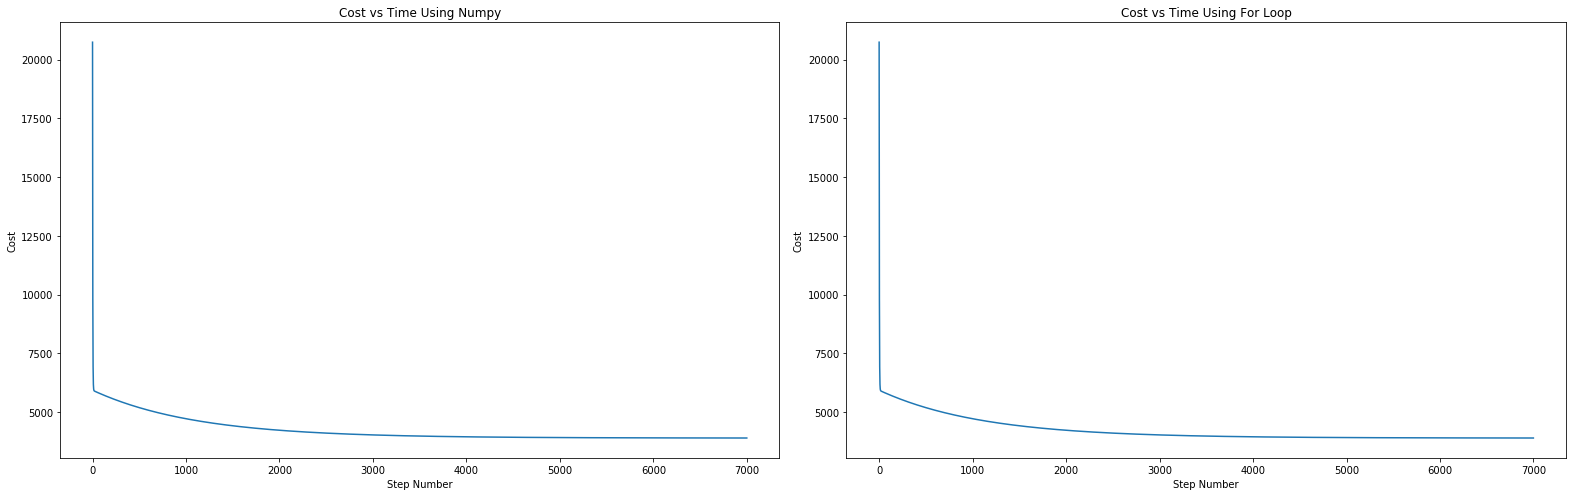

In [24]:
# Although both implementations have similar end cost, the numpy implementation was over 100x faster
plt.figure(figsize=(22,7))
plt.subplot(1, 2, 1)
plt.plot(time_seq, numpy_cost)
plt.title("Cost vs Time Using Numpy")
plt.xlabel("Step Number")
plt.ylabel("Cost")
plt.subplot(1, 2, 2)
plt.plot(time_seq, for_cost)
plt.title("Cost vs Time Using For Loop")
plt.xlabel("Step Number")
plt.ylabel("Cost")
plt.tight_layout()
plt.show()

### Now getting the predictions to determine if my model matches the performance of the sklearn linear regression model

Overall, the cost function of my simple linear regression model closely matches that of the sklearn model and as such, I believe that my model is just as effective.

$$ Prediction = (mx_i + b) $$

In [25]:
X_list = list(X)

In [26]:
def get_predictions(X, weight, bias):
    predictions = []
    for i in range(len(X)):
        pred = X[i] * weight + bias
        predictions.append(pred)
    return predictions

In [27]:
predictions = get_predictions(X_list, numpy_weight, numpy_bias)
predictions_arr = np.array(predictions)

In [28]:
# Ensuring predictions is the right shape
predictions_arr.shape = (442,1)

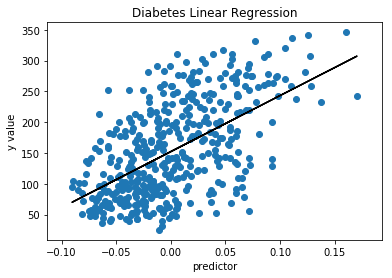

In [29]:
plt.scatter(X, y)
plt.plot(X, predictions_arr, color="black")
plt.title("Diabetes Linear Regression")
plt.xlabel("predictor")
plt.ylabel("y value")
plt.show()

## The next section of this notebook will be focused on mulivariate linear regression

Similar principles as earlier will be applied to this section of the notebook. Note that given the speed boost we saw earlier from using numpy and matrix algebra, all my new functions will be implementing these concepts.

In [30]:
# Getting a training set with multiple predictor variables
X2 = diabetes.data[:, np.newaxis, 2:5]
# Ensuring that the new X data is of the correct shape
X2.shape = (442,3)

In [31]:
# Getting a value to compare our model to
lr = LinearRegression()
lr.fit(X2, y)
predictedVals = lr.predict(X2)

print("R^2: " + str(lr.score(X2, y)))
print("Coefs: " + str(lr.coef_))
print("Intercept: " + str(lr.intercept_))

R^2: 0.39696922397726697
Coefs: [[780.74563174 393.19527108  52.90387802]]
Intercept: [152.13348416]


In [32]:
# Mean squared error to compare to in the future
mean_squared_error(y, predictedVals)

3575.9030911093523

In [33]:
# Setting the new weights for multivariate regression
weight2 = np.array([[0], 
                   [0],
                   [0]]) # corresponding with the three variables
bias2 = 0

In [34]:
# Ensuring shapes are correct
assert weight2.shape == (3,1)
assert X2.shape == (442,3)
assert y.shape == (442,1)

### Cost function for multivariate regression
$$ MSE = \frac{1}{2N}\sum_{i=1}^{n} (y_i - ((W_1x_1 + W_2x_2 + W_3x_3)+b))^2 $$
$$ \begin{split} & f^\prime(W_1) = -x_1(y-(W_1x_1 + W_2x_2 + W_3x_3+b)) \\
& f^\prime(W_2) = -x_2(y-(W_1x_1 + W_2x_2 + W_3x_3+b)) \\ 
& f^\prime(W_3) = -x_3(y-(W_1x_1 + W_2x_2 + W_3x_3+b)) \\
& f^\prime(Bias) = -(y-(W_1x_1 + W_2x_2 + W_3x_3+b) \end{split} $$

In [35]:
# Multivariate Cost function with numpy
def get_multi_cost(X, y, weight, bias):
    total_error = (1/2) * np.average((y-(np.dot(X,weight)+bias))**2)
    return total_error

In [36]:
# Testing the cost function
acost = get_multi_cost(X2, y, weight2, bias2)
acost

14537.240950226244

In [37]:
def update_multi_weights(X, y, weight, bias, lr=0.01):
    """
    weight: shape (1,3)
    X: shape(442,3)
    y: shape(442,1)
    output: shape(3,1)
    """
    df_dm = (1/len(X)) * np.dot((-X.T), (y-(np.dot(X,weight)+bias)))
    df_db = np.average(-(y-(np.dot(X,weight)+bias)))
    weight = weight - (lr * df_dm)
    bias = bias - (lr * df_db)
    return weight,bias

In [38]:
weight2,bias2 = update_multi_weights(X2,y,weight2,0.1)

In [39]:
assert weight2.shape == (3,1)
weight2

array([[0.02148044],
       [0.01617063],
       [0.00776594]])

In [40]:
# Training loop for multivariate regression
def train_multi(X, y, weight, bias, iters, lr=0.01):
    cost = []
    for i in range(iters):
        weight,bias = update_multi_weights(X,y,weight,bias,lr)
        a_cost = get_multi_cost(X, y, weight,bias)
        cost.append(a_cost)

    return cost, weight,bias

In [41]:
multi_weight = np.array([[0],[0],[0]])
multi_bias = 0
assert multi_weight.shape == (3,1)

In [42]:
cost,multi_weight,multi_bias = train_multi(X2, y, multi_weight, multi_bias, 17000, 0.1)

In [43]:
time_multi = [i for i in range(17000)]

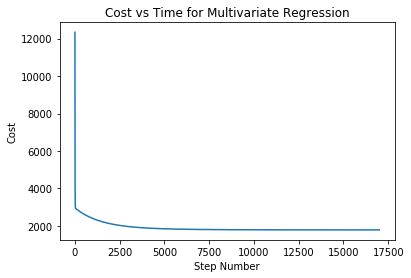

In [44]:
plt.plot(time_multi, cost)
plt.title("Cost vs Time for Multivariate Regression")
plt.xlabel("Step Number")
plt.ylabel("Cost")
plt.show()

In [45]:
# These two cost values should be very similar
print("Final cost:", cost[-1]*2) # note - multiplied by 2 b/c my cost has an additional 1/2 factor
print("Should be around:", mean_squared_error(y, predictedVals))

Final cost: 3577.4637162915665
Should be around: 3575.9030911093523


In [46]:
# This is compared to [[780.74563174 393.19527108  52.90387802]]
multi_weight

array([[754.42023889],
       [405.11293856],
       [ 67.38031489]])

In [47]:
# This is compared to [152.13348416]
multi_bias

152.13348416289637

### Finally, I will normalize my input data to see if it affects my cost in any way

$$ x_i = \frac{x_i - mean(X)}{max(X)-min(X)} $$

In [48]:
def normalize(X):
    for feat in X.T:
        mean = np.mean(feat)
        rang = np.max(feat) - np.min(feat)
        feat = (feat - mean) / rang
    return X

In [49]:
# Getting the cost from using normalized data to see if there is any improvement
X2_norm = normalize(X2)
multi_bias = 0
multi_weight = np.array([[0],[0],[0]])

cost,multi_weight,multi_bias = train_multi(X2, y, multi_weight, multi_bias, 17000, 0.1)

# There is an insignificant difference from the normalization
print("Final cost:",cost[-1]*2)

Final cost: 3577.4637162915665
